# ViewNormalization is all you need

# Library

In [1]:
import yaml
import glob
import os
import seaborn as sns
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt


#### Plot_bar

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(df, X="",  Y="", legend=None):
    # when Y is a list, X is the x-axis, plot the bars with same x axis
    if isinstance(Y, list) and X:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the first column as a bar chart
        ax.bar(df[X], df[Y[0]], label=Y[0], color='#3b6291')

        # If there's a second column, plot it as a line
        if len(Y) > 1:
            ax2 = ax.twinx()
            ax2.plot(df[X], df[Y[1]], color='#943c39', label=Y[1])
            ax2.set_ylabel(Y[1])

        ax.set_xlabel(X)
        ax.set_ylabel(Y[0])
        fig.legend(loc="upper right")
        plt.title(f"Bar and Line Plot: {Y} by {X}")

        # Remove grids for each axes
        ax.grid(False)
        if 'ax2' in locals():
            ax2.grid(False)

        plt.tight_layout()
        plt.show()


    # when 'X' and 'Y' are specified, but legend is None
    elif X and Y and legend is None:
        plt.figure(figsize=(10, 6))
        plt.bar(df[X], df[Y])
        plt.xlabel(X, fontsize=12)
        plt.ylabel(Y, fontsize=12)
        plt.title(f"Bar Plot: {Y} by {X}", fontsize=14)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

    # when 'X', 'legend', and 'Y' are specified
    elif X and legend and Y:
        grouped_df = df.groupby([X, legend])[Y].sum().unstack()

        bar_width = 0.2  # Adjusted bar width
        index = np.arange(len(grouped_df.index))* 0.7
        
        # Dynamically adjust figure size
        fig_width = len(grouped_df.index) * bar_width * 8
        plt.figure(figsize=(fig_width, 6))

        styles = [('white', 'k', '...'), ('white', 'k', '//')]  # Styles for each category
        
        for i, (colname, data) in enumerate(grouped_df.iteritems()):
            color, ec, hatch = styles[i % len(styles)]
            plt.bar(index + i * bar_width, data, width=bar_width, color=color, ec=ec, lw=0.8, hatch=hatch, label=colname)
        
        plt.xlabel(X, fontsize=12)
        plt.ylabel(Y, fontsize=12)
        plt.title(f"Grouped Bar Plot: {Y} by {X} and {legend}", fontsize=14)
        plt.xticks(index + bar_width/2, grouped_df.index, rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title=legend)
        
        plt.grid(axis='y', linestyle='--')
        
        plt.tight_layout()
        plt.show()

    else:
        print("Please specify 'X', 'legend', and 'Y' parameters.")


#### Compare Curve

In [3]:
def compare_curve(reg_exp1, reg_exp2, file_list=[]):
    # Find all directories matching pattern
    dirs = glob.glob(reg_exp1)
    dirs = [dir for dir in dirs if os.path.isdir(dir)]

    # Prepare a color cycle for plot lines
    colors = ['#3b6291', '#943c39', '#779043', '#624c7c', '#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']

    # Determine the number of rows and columns based on the length of file_list
    num_rows = len(file_list)
    num_cols = 1  # Always 1 column in this case

    # Calculate the figure size based on the number of rows and columns
    figsize = (10, 5 * num_rows)

    # Create main figure and axis
    fig, axes = plt.subplots(num_rows, num_cols, sharex=True, figsize=figsize)

    # Generate plot title based on the files to be plotted
    title = ', '.join([file.replace('_', ' ').title() for file in file_list]) + ' Over Epochs'
    fig.suptitle(title)

    flag = True
    x_min, x_max = float('inf'), float('-inf')  # Initialize min and max values for x-axis limits

    for i, dir in enumerate(dirs):
        # Extract value from directory name
        value = re.search(reg_exp2, dir).group(1)

        dfs = []
        for file_name in file_list:
            try:
                # Read the CSV files
                df = pd.read_csv(f"{dir}/default_{file_name}.csv")
            except FileNotFoundError:
                print(f"No file named 'default_{file_name}.csv' in directory '{dir}'")
                continue

            try:
                df_others = pd.read_csv(f"{dir}/default_others.csv")
            except FileNotFoundError:
                df_others = pd.read_csv(f"{dir}/default_epoch.csv")

            # Merge the dataframes on 'step'
            df = df.merge(df_others, on='step', how='inner')

            # Group by 'epoch' and calculate mean
            df = df.groupby('epoch').mean().reset_index()
            dfs.append(df)

            # Plot
            if num_rows > 1:
                axes[file_list.index(file_name)].plot(df['epoch'], df[file_name], color=colors[i], label=f' {value}')
                axes[file_list.index(file_name)].set_ylabel(file_name)
                axes[file_list.index(file_name)].grid(True)
            else:
                axes.plot(df['epoch'], df[file_name], color=colors[i], label=f' {value}')
                axes.set_ylabel(file_name)
                axes.grid(True)

            # Add stable solution indicator for 'representation_std'
            if file_name == 'representation_std' and flag:
                if num_rows > 1:
                    axes[file_list.index(file_name)].axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
                    axes[file_list.index(file_name)].text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='black', va='bottom',
                                                           ha='left', fontsize=10, weight='bold')
                else:
                    axes.axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
                    axes.text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='black', va='bottom', ha='left',
                              fontsize=10, weight='bold')

            flag = False

            # Update x-axis limits
            x_min = min(x_min, df['epoch'].min())
            x_max = max(x_max, df['epoch'].max())

    # Add legend
    if num_rows > 1:
        for ax in axes:
            ax.legend(loc='best')
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            ax.set_xlim([x_min, x_max])  # Set x-axis limit based on calculated min and max values
            ax.set_ylim(bottom=x_min)  # Start the y-axis from the minimum x-value
    else:
        axes.legend(loc='best')
        axes.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        axes.set_xlim([x_min, x_max])  # Set x-axis limit based on calculated min and max values
        axes.set_ylim(bottom=x_min)  # Start the y-axis from the minimum x-value

    # Show the plots
    plt.tight_layout()
    plt.show()


#### Others

In [4]:


def check_config(reg_exp, record_list=[]):
    # Find all directories matching pattern
    dirs = glob.glob(reg_exp)
    dirs = [dir for dir in dirs if os.path.isdir(dir)]

    # Initialize dictionary to store the extracted information
    data = {}

    # Iterate over the directories and extract information from config.yaml
    for directory in dirs:
        config_path = os.path.join(directory, 'config.yaml')
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            # Check for each record in the list
            for record in record_list:
                if record in config:
                    if record not in data:
                        data[record] = [config[record]]
                    else:
                        data[record].append(config[record])
                else:
                    print(f"Record '{record}' not found in directory '{directory}'")

    # Create a DataFrame with the extracted information
    df = pd.DataFrame(data)
    
    # Add 'dir_name' column with directory names
    df['dir_name'] = dirs

    # Set 'dir_name' as the first column
    df = df.set_index('dir_name').reset_index()

    # Display the DataFrame as a table
    return df

def extract_reg(df: pd.DataFrame, pattern: str, name: str) -> pd.DataFrame:
    # Identify if the pattern targets a string, float or a number
    if 'REG' in pattern:
        reg_pattern = pattern.replace("REG", "([a-zA-Z0-9_.]+)")
    else:
        reg_pattern = pattern
        
    df[name] = df['dir_name'].apply(lambda x: re.findall(reg_pattern, x))
    
    # If the matched pattern is a number or a float, convert it accordingly
    df[name] = df[name].apply(lambda x: int(x[0]) if x and x[0].isdigit() else 
                               (float(x[0]) if x and is_float(x[0]) else (x[0] if x else None)))
    return df

def is_float(n):
    try:
        float_n = float(n)
    except ValueError:
        return False
    else:
        return '.' in n

def plot_lines(df, column):
    # Use seaborn styles
    sns.set_style("whitegrid")
    
    df = df.sort_values(by=column)
    
    plt.figure(figsize=(10, 6))
    
    # Plotting each of the accuracy measures with different line styles and colors
    plt.plot(list(df[column]), df['linear_top1_accuracy'], label='Top-1 Accuracy', linestyle='-', color='blue')
    plt.plot(list(df[column]), df['linear_top3_accuracy'], label='Top-3 Accuracy', linestyle='--', color='green')
    plt.plot(list(df[column]), df['linear_top1_average_accuracy'], label='Top-1 Avg Accuracy', linestyle='-.', color='red')
    plt.plot(list(df[column]), df['linear_knn_top1_accuracy'], label='KNN Top-1 Accuracy', linestyle=':', color='purple')
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy Measures over ' + column, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.show()


def plot_perform(df, column):
    # Use seaborn styles
    sns.set_style("whitegrid")
    
    df = df.sort_values(by=column)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot 'GPU Usage(Gbyte)' on the first y-axis (left)
    ax1.plot(list(df[column]), df['GPU Usage(Gbyte)'], label='GPU Usage(Gbyte)', linestyle='-', color='blue')
    ax1.set_ylabel('GPU Usage (Gbyte)', fontsize=12)
    
    ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis

    # Plot 'running time(min)' on the secondary y-axis (right)
    ax2.plot(list(df[column]), df['runing time(min)'], label='runing time(min)', linestyle='--', color='green')
    ax2.set_ylabel('Running Time (min)', fontsize=12)
    
    plt.xlabel(column, fontsize=12)
    plt.title('Performances over ' + column, fontsize=14)
    
    # Combine the legends from both plots
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)
    
    plt.grid(True)
    plt.show()


In [5]:


# Define function to create bar plot
def plot_bar(df, axis="", legend="", metric=""):
    if axis and legend and metric:
        grouped_df = df.groupby([axis, legend])[metric].sum().unstack()

        bar_width = 0.2  # Adjusted bar width
        index = np.arange(len(grouped_df.index))* 0.7
        
        # Dynamically adjust figure size
        fig_width = len(grouped_df.index) * bar_width * 8
        plt.figure(figsize=(fig_width, 6))

        styles = [('white', 'k', '...'), ('white', 'k', '//')]  # Styles for each category
        
        for i, (colname, data) in enumerate(grouped_df.iteritems()):
            color, ec, hatch = styles[i % len(styles)]
            plt.bar(index + i * bar_width, data, width=bar_width, color=color, ec=ec, lw=0.8, hatch=hatch, label=colname)
        
        plt.xlabel(axis, fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.title(f"Grouped Bar Plot: {metric} by {axis} and {legend}", fontsize=14)
        plt.xticks(index + bar_width/2, grouped_df.index, rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title=legend)
        
        plt.grid(axis='y', linestyle='--')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Please specify 'axis', 'legend', and 'metric' parameters.")
 

In [6]:
def show_batch_variance(root):
    # Read the CSV files
    df_std = pd.read_csv(root + 'default_representation_std.csv')
    df_loss = pd.read_csv(root + 'default_correlation.csv')
    df_accuracy = pd.read_csv(root + 'default_kNN_accuracy.csv')

    # Create main figure and axis with larger size
    fig, ax1 = plt.subplots(figsize=(10, 6))



    # Plot kNN Accuracy
    color = 'tab:green'
    ax1.set_xlabel('Step')
    ax1.set_ylabel('kNN Accuracy', color=color)
    line3, = ax1.plot(df_accuracy['step'], df_accuracy['kNN_accuracy'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y axis for Train Loss
    ax2 = ax1.twinx()
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:red'
    ax2.set_ylabel('batch_correlation', color=color)
    line2, = ax2.plot(df_loss['step'], df_loss['correlation'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Create third y axis for Standard Deviation
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:blue'
    ax3.set_ylabel('Standard Deviation', color=color)
    line1, = ax3.plot(df_std['step'], df_std['representation_std'], color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim (0.1**2,2 **1)
    ax3.set_yscale("log")

    ax3.axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
    ax3.text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='blue', va='bottom', ha='left', fontsize=10, weight='bold')
    plt.title('Variance between Batch over Steps')
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    # Show the plots
    fig.tight_layout()
    plt.show()
 

def plot_metrics_together(root, metrics):
    # Create main figure and axis with larger size
    fig, ax1 = plt.subplots(dpi=100)
    fig.subplots_adjust(right=0.75)
    # The 'tab:' style provides 10 distinct colors. We use all of them for variety.
    colors = [ 'green', 'red','blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Iterate through the metrics
    for i, metric in enumerate(metrics):
        # Read the CSV files
        df_metric = pd.read_csv(root + f'default_{metric}.csv')

        # Plot the first metric on the left y-axis
        if i == 0:
            ax1.set_xlabel('Step')
            ax1.set_ylabel(metric, color=colors[i])
            line, = ax1.plot(df_metric['step'], df_metric[metric], color=colors[i])
            ax1.tick_params(axis='y', labelcolor=colors[i])
            ax1.grid(False)

        # Plot the other metrics on the right y-axis
        else:
            ax = ax1.twinx()
            if i > 1:  # shift the y-axis for the 3rd, 4th, ... metrics
                ax.spines['right'].set_position(('outward', 60*(i-1)))
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

            ax.set_ylabel(metric, color=colors[i % 10])
            line, = ax.plot(df_metric['step'], df_metric[metric], color=colors[i % 10])
            ax.tick_params(axis='y', labelcolor=colors[i % 10])
            ax.grid(False)

    # Set the plot title
    plt.title('Metrics over Steps')

    # Show the plots
    fig.tight_layout()
    plt.show()
import math
 
def plot_metrics_separately(root, metrics):
    # Calculate the number of rows needed for the grid
    rows = math.ceil(len(metrics) / 5)

    # Create a new figure and subplots
    fig, axs = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    
    # In case there's only one row, we need to convert axs to a 2D array
    if rows == 1:
        axs = np.expand_dims(axs, 0)

    # Iterate over each metric
    for i, metric in enumerate(metrics):
        # Calculate the current row and column
        row = i // 5
        col = i % 5

        # Read the CSV file
        df_metric = pd.read_csv(root + f'default_{metric}.csv')

        # Plot the metric
        axs[row, col].plot(df_metric['step'], df_metric[metric], color='blue')
        axs[row, col].set_title(metric)
        axs[row, col].set_xlabel('Step')
        axs[row, col].set_ylabel(metric)

    # If the total number of metrics is not a multiple of 5, we need to remove the empty subplots
    if len(metrics) % 5 != 0:
        for col in range(len(metrics) % 5, 5):
            fig.delaxes(axs[rows - 1, col])

    # Show the plots
    plt.tight_layout()
    plt.show()
    
import scipy.stats

import pandas as pd
import scipy.stats
import numpy as np

import warnings
import scipy.stats


import warnings
import scipy.stats

import pandas as pd
import seaborn as sns
import numpy as np

def plot_correlation_matrix(root, metrics):
    # Initialize an empty DataFrame to store our metrics data
    df = pd.DataFrame()

    # Read the data for each metric and add it to the DataFrame
    for metric in metrics:
        df_metric = pd.read_csv(root + f'default_{metric}.csv')
        df[metric] = df_metric[metric]

    # Initialize an empty matrix to store our correlations
    correlations = np.zeros((len(metrics), len(metrics)))

    # Calculate the correlations for each pair of metrics
    for i, metric1 in enumerate(metrics):
        for j, metric2 in enumerate(metrics):
            if i != j:
                # Get the steps for the metrics with the smaller number of steps
                steps = df[metric1].index if len(df[metric1]) <= len(df[metric2]) else df[metric2].index
                
                # Interpolate the values for the other metric at these steps
                interpolated_values = np.interp(steps, df[metric2].index, df[metric2])
                
                # Compute the correlation and store it in the matrix
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        correlation, _ = scipy.stats.pearsonr(df[metric1][steps], interpolated_values)
                    except Warning:
                        correlation = 0.0
                correlations[i, j] = correlation
            else:
                correlations[i, j] = 1
    # Create a DataFrame from the correlation matrix
    df_correlations = pd.DataFrame(correlations, index=metrics, columns=metrics)
    plt.figure(figsize=(12, 12))
    # Create a heatmap from the DataFrame
    sns.heatmap(df_correlations, annot=True, cmap='coolwarm')

    # Show the plot
    plt.show()
from sklearn.linear_model import LinearRegression

def perform_regression(root, metrics):
    # Initialize an empty DataFrame to store our metrics data
    df = pd.DataFrame()

    # Read the data for the first metric and add it to the DataFrame
    df_metric_1 = pd.read_csv(root + f'default_{metrics[0]}.csv')
    df[metrics[0]] = df_metric_1[metrics[0]]
    
    # Read the data for each other metric, interpolate it at the steps of the first metric, and add it to the DataFrame
    for metric in metrics[1:]:
        df_metric = pd.read_csv(root + f'default_{metric}.csv')
        interpolated_values = np.interp(df_metric_1['step'], df_metric['step'], df_metric[metric])
        df[metric] = interpolated_values

    # Separate the target variable (y) from the predictor variables (X)
    y = df[metrics[0]]
    X = df[metrics[1:]]

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Print the regression coefficients
    print('Intercept: ', model.intercept_)
    for metric, coef in zip(metrics[1:], model.coef_):
        print(f'Coefficient for {metric}: {coef}')
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import pandas as pd

def plot_importance_byDT(roots, metrics):
    # Initialize an empty list to store our metrics data
    dfs = []

    for root in roots:
        # Temporary DataFrame for this root
        df_temp = pd.DataFrame()

        # Read the data for the first metric and add it to the DataFrame
        df_metric_1 = pd.read_csv(root + f'default_{metrics[0]}.csv')
        df_temp[metrics[0]] = df_metric_1[metrics[0]]

        # Read the data for each other metric, interpolate it at the steps of the first metric, and add it to the DataFrame
        for metric in metrics[1:]:
            df_metric = pd.read_csv(root + f'default_{metric}.csv')
            interpolated_values = np.interp(df_metric_1['step'], df_metric['step'], df_metric[metric])
            df_temp[metric] = interpolated_values

        # Append this root's DataFrame to the list of DataFrames
        dfs.append(df_temp)

    # Concatenate all DataFrames in the list into a single DataFrame
    df = pd.concat(dfs)

    # Separate the target variable (y) from the predictor variables (X)
    y = df[metrics[0]]
    X = df[metrics[1:]]

    # Create and fit the model
    model = DecisionTreeRegressor()
    model.fit(X, y)

    # Print the feature importances
    print('Feature importances:')
    feature_importances = []
    for metric, importance in zip(metrics[1:], model.feature_importances_):
        #print(f'{metric}: {importance}')
        feature_importances.append((metric, importance))
        
    # Sort features by importance
    feature_importances.sort(key=lambda x: x[1], reverse=False)

    # Plot the feature importances
    plt.figure(figsize=(5, 10))
    plt.barh([x[0] for x in feature_importances], [x[1] for x in feature_importances])
    plt.ylabel('Features')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()



def plot_metrics_separately_p(root, metrics, col_num=5):
    # Calculate the number of rows and cols needed for the grid
    rows = math.ceil(len(metrics) / col_num)
    cols = col_num

    # Create a new figure and subplots
    fig, axs = plt.subplots(rows, cols, figsize=() )
    
    # In case there's only one row, we need to convert axs to a 2D array
    if rows == 1:
        axs = np.expand_dims(axs, 0)

    # Read the CSV file for the first metric
    df_metric_1 = pd.read_csv(root + f'default_{metrics[0]}.csv')

    # Iterate over each metric
    for i, metric in enumerate(metrics):
        # Calculate the current row and column
        row = i // cols
        col = i % cols

        # Read the CSV file
        df_metric = pd.read_csv(root + f'default_{metric}.csv')

        # Plot the metric
        axs[row, col].plot(df_metric['step'], df_metric[metric], color='blue')

        # If it's not the first metric, compute the correlation with the first metric
        if i != 0:
            # Interpolate values for the current metric at the steps of the first metric
            interpolated_values = np.interp(df_metric_1['step'], df_metric['step'], df_metric[metric])

            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    correlation, _ = scipy.stats.pearsonr(interpolated_values, df_metric_1[metrics[0]])
                except Warning:
                    correlation = 0.0

            axs[row, col].set_title(f'{metric} (p: {correlation:.2f})')
        else:
            axs[row, col].set_title(metric)

        axs[row, col].set_xlabel('Step')
        axs[row, col].set_ylabel(metric)

    # If the total number of metrics is not a multiple of row_num, we need to remove the empty subplots
    if len(metrics) % col_num != 0:
        for col in range(len(metrics) % col_num, col_num):
            fig.delaxes(axs[rows - 1, col])

    # Show the plots
    plt.tight_layout()
    plt.show()  
    

# Abstract

# Method


1. According to the Information Bottleneck (IB) theory, the optimal representation, $Z_X^*$, maximizes the mutual information with the task $T$ while minimizing the mutual information with the input data $X$. Mathematically: For a given task, we want 

    $$Z_X^* = \underset{Z_X}{\arg \min} I(Z_X ; X) \text { s.t. } I(Z_X ; T) \text { is maximized}.$$

2. For self-supervised learning, the aim is to find a representation that maximizes the mutual information with the task, while minimizing the mutual information with the specific data augmentations (denoted as "Aug"). We also add a constraint to maximize the variance of $Z$ over the batch. The optimization problem becomes:

   $$Z_X^* = \underset{Z_X}{\arg \min} I(Z_X ; \text{Aug}(X)) \text { s.t. } I(Z_X ; T) \text { is maximized, } \quad \sigma^2(Z_X) \text{ over the batch is maximized}.$$

Where $\sigma^2(Z_X)$ denotes the variance of $Z_X$ over the batch. This additional constraint encourages the model to learn diverse representations across different instances in the batch.

3. In the two-views case, the objective is to minimize the distance between the representations of the two views of the same instance. Formally: 

    $$\text{loss} = \text { distance}(z_{0, j, k}, z_{1,j, k}).$$ 

4. In the multi-view case, 

Let's define $X = \{x_0, x_1, ..., x_n\}$ as the different augmented views of the original data and $Z = \{z_0, z_1, ..., z_n\}$ as the corresponding representations produced by a model $f$, where $z_i = f(x_i)$. 

a. The final objective hypothesis space we are going to learn is `z_mean` for each batch and feature across all views as follows:
 $$z_{\text{mean}_{j, k}} = \frac{1}{n} \sum_{i=0}^{n} z_{i, j, k}.$$

Where:
- `i` ranges over the different views,
- `j` is the index of the batch, and
- `k` is the index of the feature.
 
b. The objective becomes minimizing the variance of the representations across different views of the same instance: 

$$\text{loss} = \frac{1}{n} \sum_{i=0}^{n} \text{distance }(z_{i, j, k}, z_{\text{mean}_{j, k}})^2.$$

### Why it work


# Magic Cube Demo


VICREG


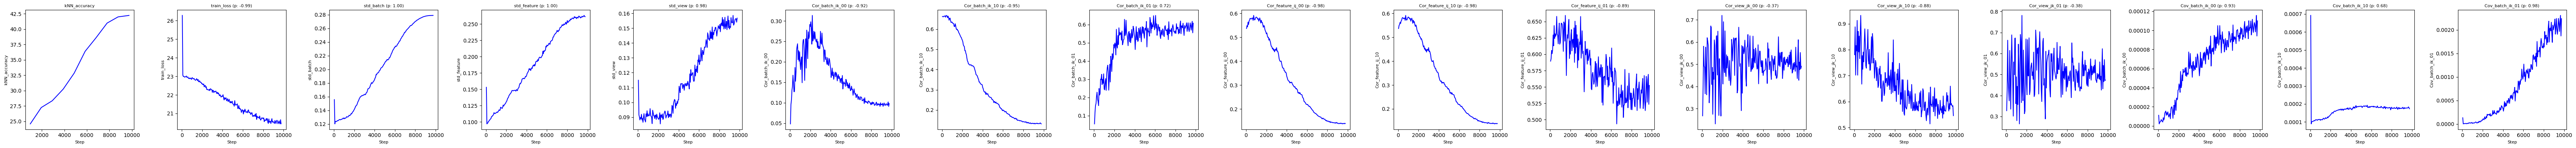

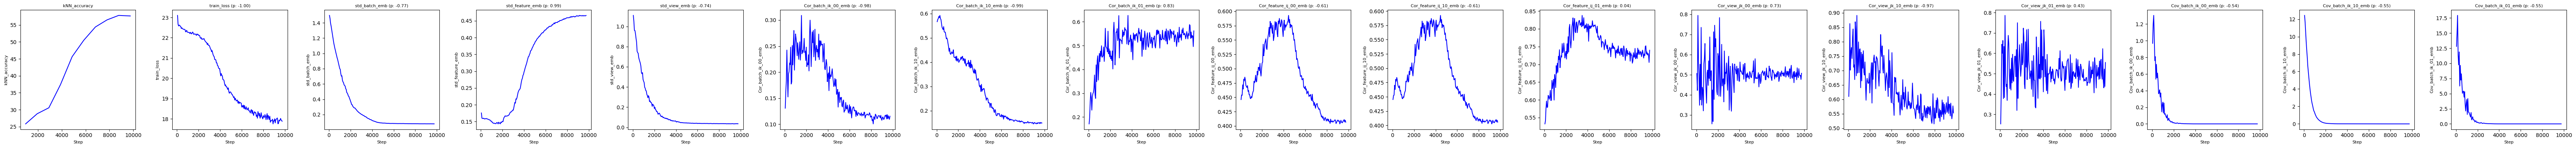

SimCLR


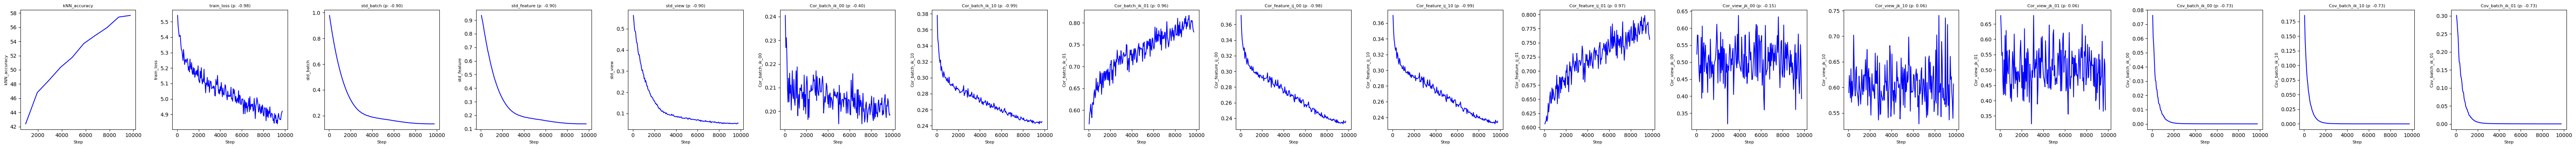

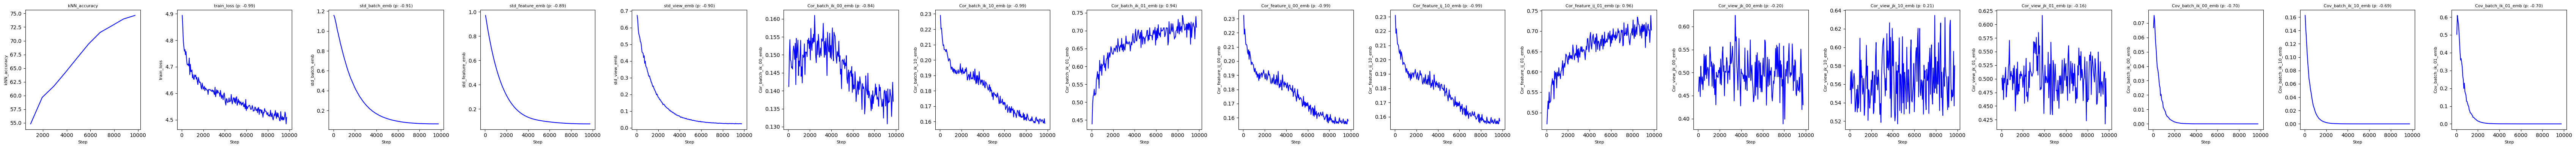

SimSiam


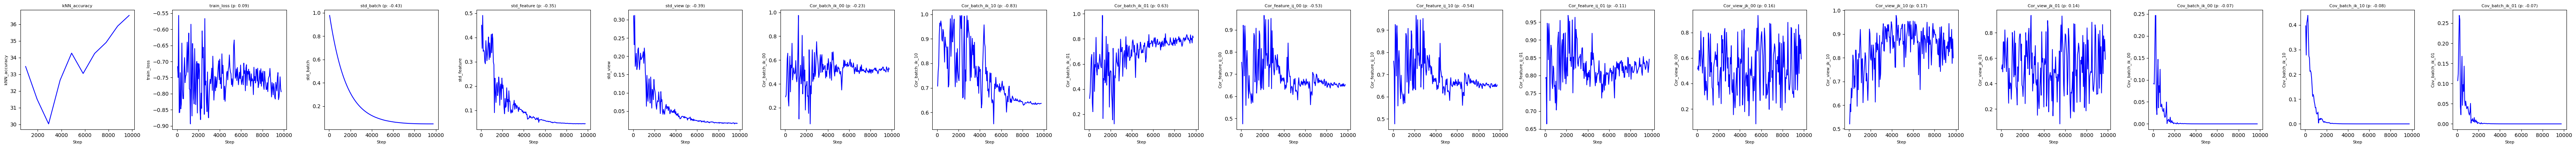

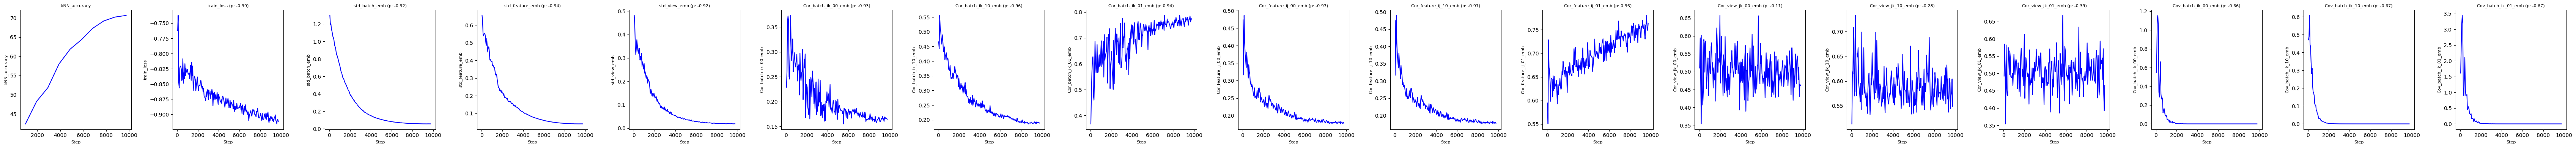

BYOL


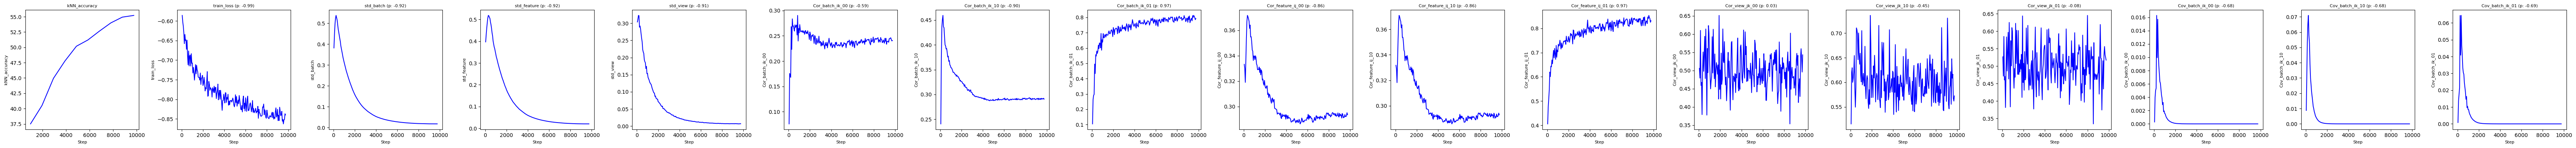

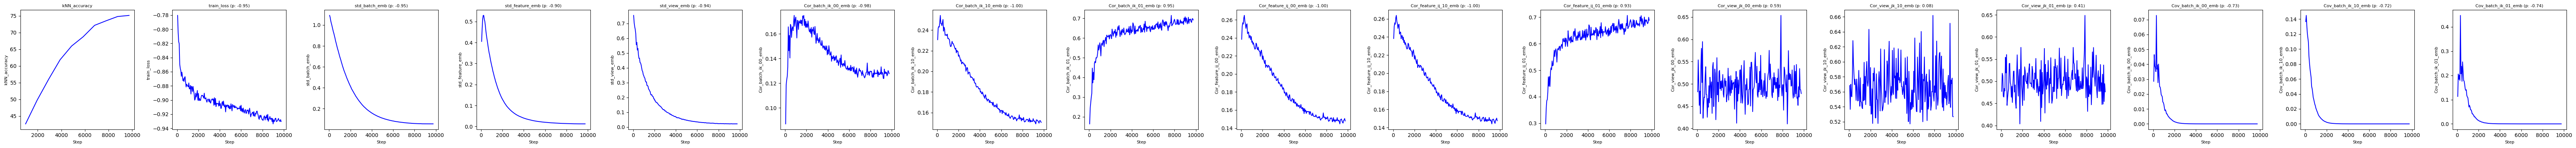

MoCo


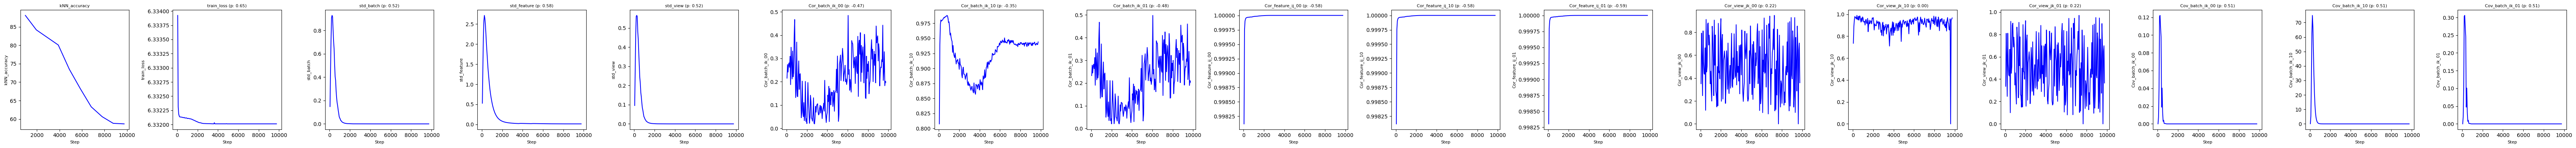

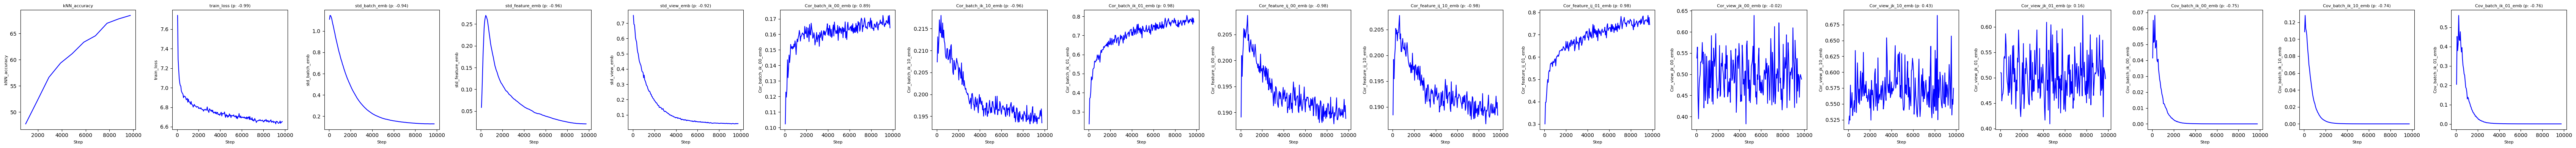

DCL


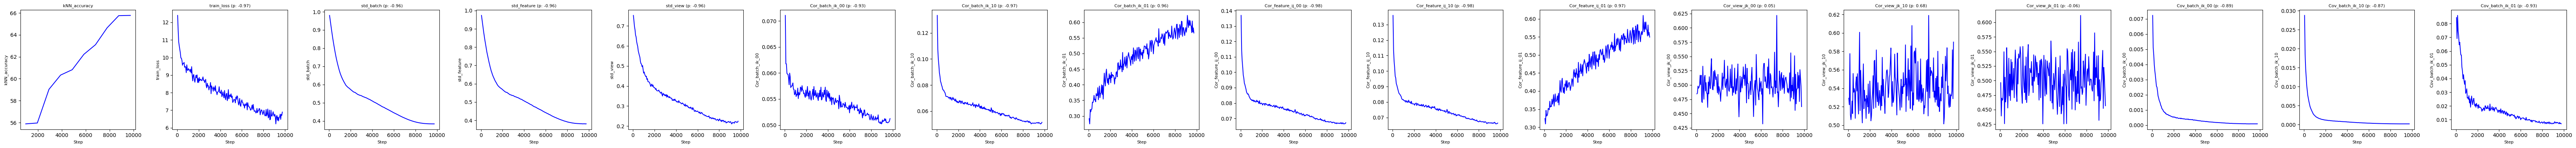

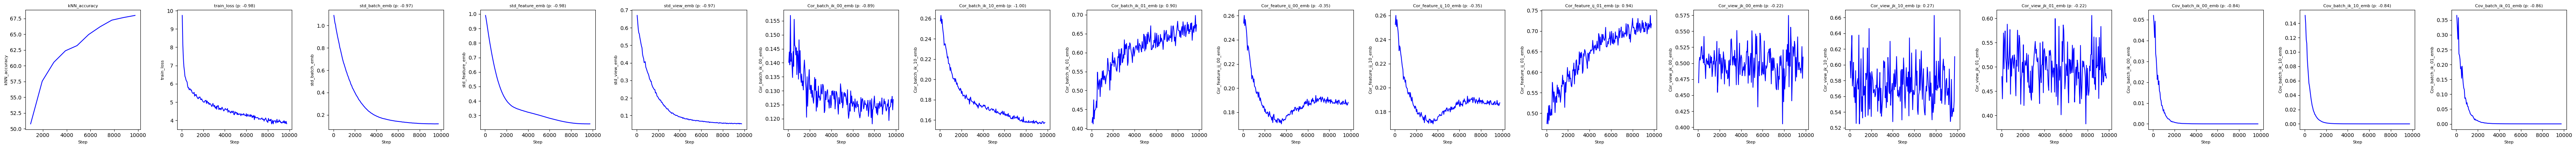

In [12]:
# For normal method it can effectively acclerate and stable the learning.
#plot_metrics_together(root="Test_1/", metrics=['kNN_accuracy','train_loss'])
#show_batch_variance(root="Model_SimCLR_VMmean_n_v4/")  
#plot_metrics_separately(root="cube_Model_VICREG_VMNone_v2/", metrics=['kNN_accuracy','train_loss','std_batch','std_feature','std_view'])
#plot_metrics_separately(root="cube_Model_VICREG_VMNone_v2/", metrics=['kNN_accuracy','train_loss','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01'])
#plot_metrics_separately(root="cube_Model_VICREG_VMNone_v2/", metrics=['kNN_accuracy','train_loss','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01'])
#plot_metrics_separately(root="cube_Model_VICREG_VMNone_v2/", metrics=['kNN_accuracy','train_loss','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01'])
#plot_metrics_separately(root="cube_Model_VICREG_VMNone_v2/", metrics=['kNN_accuracy','train_loss','Cov_batch_ik_00','Cov_batch_ik_10','Cov_batch_ik_01'])

#plot_metrics_separately(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','train_loss','std_batch','std_feature','std_view'])
#plot_metrics_separately(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','train_loss','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01'])
#plot_metrics_separately(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','train_loss','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01'])
#plot_metrics_separately(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','train_loss','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01'])
#plot_metrics_separately(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','train_loss','Cov_batch_ik_00','Cov_batch_ik_10','Cov_batch_ik_01'])
def plot_metrics_separately_p(root, metrics):
    # Set the number of columns equal to the length of metrics
    col_num = len(metrics)
    rows = 1

    # Create a new figure and subplots. Increase the width of the figure.
    fig, axs = plt.subplots(rows, col_num, figsize=(4 * col_num, 4 * rows))

    # Read the CSV file for the first metric
    df_metric_1 = pd.read_csv(root + f'default_{metrics[0]}.csv').replace([np.inf, -np.inf], np.nan).dropna()

    # Iterate over each metric
    for i, metric in enumerate(metrics):
        # Calculate the current column
        col = i

        # Read the CSV file
        df_metric = pd.read_csv(root + f'default_{metric}.csv').replace([np.inf, -np.inf], np.nan).fillna(0)

        # Plot the metric
        axs[col].plot(df_metric['step'], df_metric[metric], color='blue')

        # If it's not the first metric, compute the correlation with the first metric
        if i != 0:
            # Interpolate values for the current metric at the steps of the first metric
            interpolated_values = np.interp(df_metric_1['step'], df_metric['step'], df_metric[metric])

            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    correlation, _ = scipy.stats.pearsonr(interpolated_values, df_metric_1[metrics[0]])
                except Warning:
                    correlation = 0.0

            axs[col].set_title(f'{metric} (p: {correlation:.2f})', fontsize=8)
        else:
            axs[col].set_title(metric, fontsize=8)

        axs[col].set_xlabel('Step', fontsize=8)
        axs[col].set_ylabel(metric, fontsize=8)

    # Show the plots
    plt.tight_layout()
    plt.show()


metric_list=[['kNN_accuracy','train_loss','std_batch','std_feature','std_view'],
             ['kNN_accuracy','train_loss','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01'],
             ['kNN_accuracy','train_loss','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01'],
             ['kNN_accuracy','train_loss','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01'],
             ['kNN_accuracy','train_loss','Cov_batch_ik_00','Cov_batch_ik_10','Cov_batch_ik_01'],
]


metrics=['kNN_accuracy','train_loss','std_batch','std_feature','std_view',\
             'Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01',\
             'Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01',\
             'Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01',\
             'Cov_batch_ik_00','Cov_batch_ik_10','Cov_batch_ik_01']

metrics2=['kNN_accuracy','train_loss','std_batch_emb','std_feature_emb','std_view_emb',\
             'Cor_batch_ik_00_emb','Cor_batch_ik_10_emb','Cor_batch_ik_01_emb',\
             'Cor_feature_ij_00_emb','Cor_feature_ij_10_emb','Cor_feature_ij_01_emb',\
             'Cor_view_jk_00_emb','Cor_view_jk_10_emb','Cor_view_jk_01_emb',\
             'Cov_batch_ik_00_emb','Cov_batch_ik_10_emb','Cov_batch_ik_01_emb']
models=["VICREG","SimCLR","SimSiam","BYOL","MoCo","DCL"]  #"BarlowTwins",

for model in models:
    pass
    print(model)
    
#for i in range(5):    

    plot_metrics_separately_p(root=f"BaseNoneV4/Base_md{model}_VMNone_ep50_v4/", metrics=metrics[0:])
    plot_metrics_separately_p(root=f"Base_md{model}_VMmean_n_ep50_v4/", metrics=metrics2[0:])
 

In [16]:
!pip show lightly 

Name: lightly
Version: 1.4.8
Summary: A deep learning package for self-supervised learning
Home-page: 
Author: Philipp Wirth & Igor Susmelj
Author-email: philipp@lightly.ai
License: MIT
Location: c:\users\isxzl\anaconda3\envs\autogpt\lib\site-packages
Requires: aenum, certifi, hydra-core, lightly-utils, numpy, pydantic, python-dateutil, pytorch-lightning, requests, setuptools, six, torch, torchvision, tqdm, urllib3, urllib3
Required-by: 


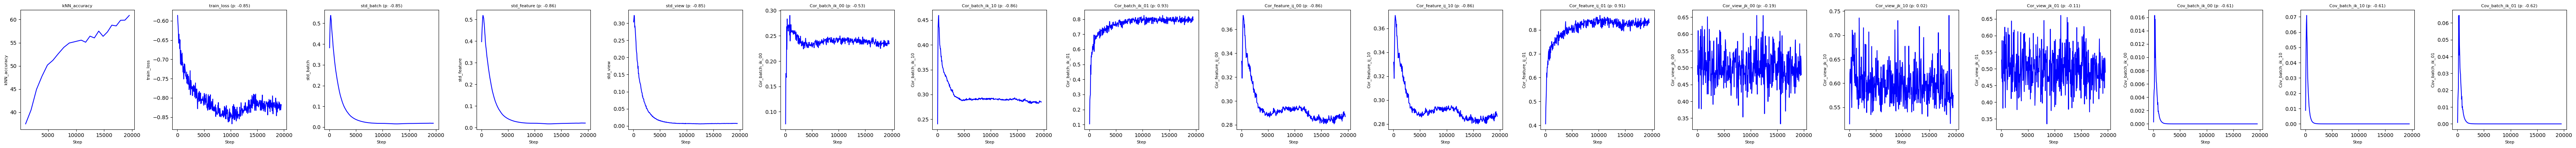

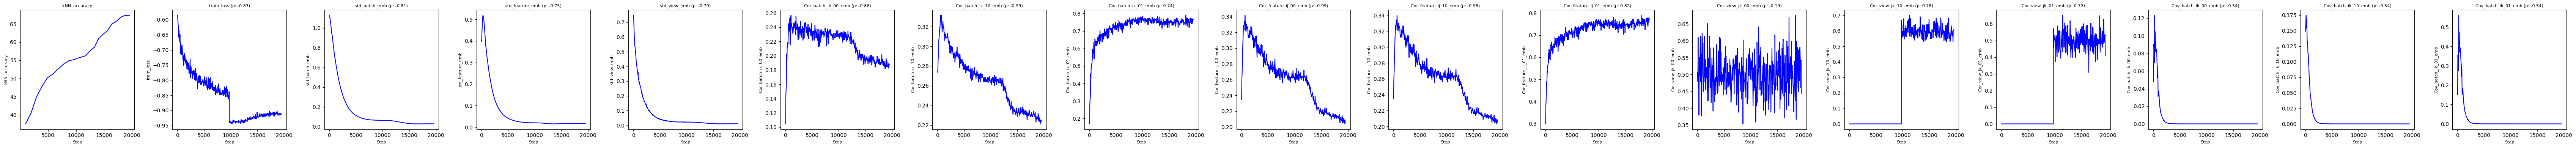

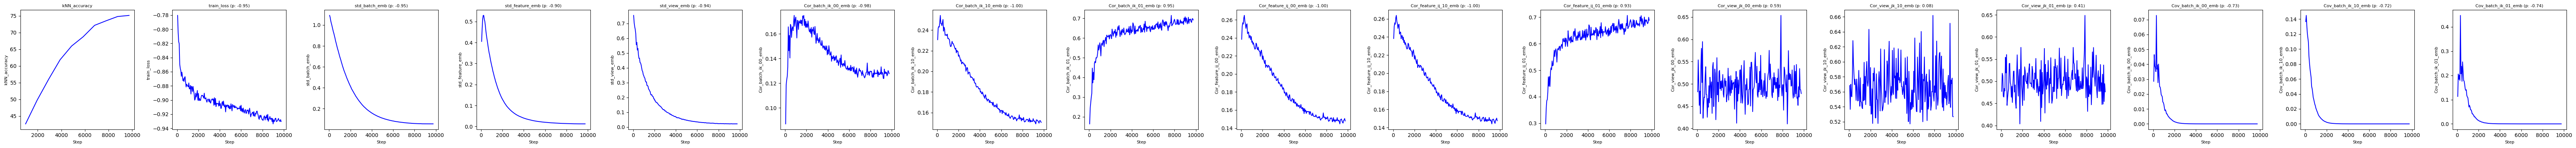

In [15]:
plot_metrics_separately_p(root=f"Con_mdBYOL_VMNone_ep50_v4_Default/", metrics=metrics[0:])
plot_metrics_separately_p(root=f"Con_mdBYOL_VMNone_ep50_v4_Our/", metrics=metrics2[0:])
plot_metrics_separately_p(root=f"Base_mdBYOL_VMmean_n_ep50_v4/", metrics=metrics2[0:])
  

# Whats the Main Focus

1. Most of them rise.
1. Strong Correlation
2. result in a bad converge/Collapse
3. Common patterns



# Whats

In [8]:

models=["BarlowTwins","SimCLR","SimSiam","BYOL","MoCo"]
roots=[]
for model in models:
    roots.append(f"Base_md{model}_ep50_v4/")
    
# Usage:
# plot_feature_importance(roots=["root1/", "root2/", "root3/"], metrics=['kNN_accuracy','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01','Cor_batch_ik

# Usage:
# plot_feature_importance(roots=["root1/", "root2/", "root3/"], metrics=['kNN_accuracy','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01','std_batch','std_feature','std_view'])
  
plot_importance_byDT(roots=roots, metrics=['kNN_accuracy','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01','std_batch','std_feature','std_view'])


#plot_correlation_matrix(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01','std_batch','std_feature','std_view'])
#perform_regression(root="cube_Model_VICREG_VMmean_n_v4/", metrics=['kNN_accuracy','Cor_view_jk_00','Cor_view_jk_10','Cor_view_jk_01','Cor_feature_ij_00','Cor_feature_ij_10','Cor_feature_ij_01','Cor_batch_ik_00','Cor_batch_ik_10','Cor_batch_ik_01','std_batch','std_feature','std_view'])
 

FileNotFoundError: [Errno 2] No such file or directory: 'Base_mdBarlowTwins_ep50_v4/default_kNN_accuracy.csv'

#### (Important) fix the unbalance problem(bottleneck of VICREG and BT)
 
    
<u>**its focus too much on invariance, so that batch correlation and view variance is not good**

In [ ]:
show_batch_variance(root="Model_VICREG_VMmean_n_v4/")
show_batch_variance(root="Model_VICREG_VMNone_v2/") 
plot_metrics_together(root="Model_VICREG_VMNone_v2//", metrics=['kNN_accuracy','train_loss'])
plot_metrics_together(root="Model_VICREG_VMmean_n_v4//", metrics=['kNN_accuracy','train_loss'])

plot_metrics_together(root="cube_Model_VICREG_VMNone_v2//", metrics=['kNN_accuracy','train_loss'])
plot_metrics_together(root="cube_Model_VICREG_VMmean_n_v4//", metrics=['kNN_accuracy','train_loss'])

#### <u>**2. Global and Local Feature, Cover More  mutual information (MI) </u>**

`Formula to suggest why`



#### <u>**3. Global and Local Feature, Cover More  mutual information (MI) </u>**

`Formula to suggest why`



#### <u>**4. Add numeric stable to Avoid Multi variate distribution </u>**


In [ ]:
ds = check_config("Base*", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])
ds